# 1 Introdução

Nos exemplos anteriores testamos o OpInf em problemas monofásicos sintéticos para 1D e 3D. Vamos agora aplicar num modelo numérico real. O modelo escolhido é o Unisim que foi adaptado para trabalhar somente com uma fase.


![Texto alternativo](unisim.png)


## 1.1 Rodar os simulador

Rode o arquivo UNISIM-I-M_29_S02.dat

## 1.2 Visualização

Observe os resultados no Results do CMG ou qualquer outro pós processador. É um modelo um pouco mais elaborado que roda em torno de um minuto, a depender da máquina.

## 1.3 Exportar os dados


Existem várias formas de se exportar os dados simulados para o Python ou qualquer outra linguagem de programação. Fique à vontade para fazer da sua forma. Neste trabalho foi utilizado originalmente o Results Report do CMG. Rode os arquivos "*.rwd" no "Report.exe" do CMG. Como saída vão ser gerados 3 arquivos .rwo

# 2 OpInf nos dados de grid

## 2.1 Inicialização

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
n=81*58*20 #número de células

In [14]:
# carregar dados de vazão por completação
dados = np.loadtxt('UNISIM_QL_S02.rwo', skiprows=6)
U=dados[1:,67:].T # removendo os injetores
p=U.shape[0]
tempo=dados[:,0]
tempo[0]=0
dt=tempo[1:]-tempo[:-1]


k=tempo.shape[0]-1 #número de passos de tempo, exceto o tempo inicial

# carregar dados de pressão de fundo por poço
dados = np.loadtxt('UNISIM_PWF_S02.rwo', skiprows=6)
PWF=dados[1:,12:].T # removendo os injetores
q=PWF.shape[0]

In [15]:
# carregar dados de pressão do grid. By chatgpt.

def extrair_matriz_pressao(filepath, NX=81, NY=58, NZ=20):
    n_celulas = NX * NY * NZ
    linhas_por_bloco = (NX + 6) // 7  # assume 7 valores por linha

    with open(filepath, 'r') as f:
        linhas = f.readlines()

    tempos = []
    matrizes = []
    linha_atual = 0
    total_linhas = len(linhas)

    while linha_atual < total_linhas:
        linha = linhas[linha_atual]

        # Detecta novo tempo
        if linha.startswith('**  TIME'):
            tempo = linha.split('=')[1].strip()
            tempos.append(tempo)

            # Avança até encontrar 'PRES ALL'
            while linha_atual < total_linhas and not linhas[linha_atual].strip().startswith('PRES ALL'):
                linha_atual += 1
            linha_atual += 1  # pula a linha 'PRES ALL'

            bloco = np.empty(n_celulas, dtype=np.float32)
            idx = 0

            # Loop sobre os blocos de K, J
            while linha_atual < total_linhas:
                linha = linhas[linha_atual]

                if linha.startswith('** K'):
                    linha_atual += 1
                    for _ in range(linhas_por_bloco):
                        valores = linhas[linha_atual].split()
                        bloco[idx:idx+len(valores)] = [float(v) for v in valores]
                        idx += len(valores)
                        linha_atual += 1

                elif linha.startswith('**  TIME') or linha.strip() == '':
                    break

                else:
                    linha_atual += 1

            matrizes.append(bloco)

        else:
            linha_atual += 1

    matriz_pressao = np.column_stack(matrizes)
    return matriz_pressao

dados =extrair_matriz_pressao("UNISIM_PRESS_S02.rwo",NX=81, NY=58, NZ=20)
Xorig=dados.copy()
x0=Xorig[:,0].copy()
X=Xorig[:,1:].copy()

### 🧩 Tabela de Células das primeiras completações dos poços

|  # | Poço     | I  | J  | K  | Célula # |PWF |
|----|----------|----|----|----|----------|----|
|  1 | NA1A     | 38 | 36 | 1  |  2873    |  1 |
|  2 | NA2      | 21 | 36 | 1  |  2856    | 17 |
|  3 | NA3D     | 44 | 43 | 1  |  3446    | 27 |
|  4 | RJS19    | 31 | 27 | 1  |  2137    | 96 |
|  5 | PROD005  | 33 | 21 | 3  | 11049    | 36 |
|  6 | PROD008  | 19 | 32 | 1  |  2530    | 42 |
|  7 | PROD009  | 15 | 42 | 7  | 31524    | 48 |
|  8 | PROD010  | 36 | 44 | 1  |  3519    | 54 |
|  9 | PROD012  | 46 | 24 | 1  |  1909    | 60 |
| 10 | PROD014  | 50 | 20 | 1  |  1589    | 66 |
| 11 | PROD021  | 27 | 43 | 1  |  3429    | 72 |
| 12 | PROD023A | 65 | 25 | 8  | 34895    | 78 |
| 13 | PROD024A | 61 | 37 | 2  |  7675    | 84 |
| 14 | PROD025A | 57 | 25 | 6  | 25491    | 90 |

## 2.2 Histórico e Previsão

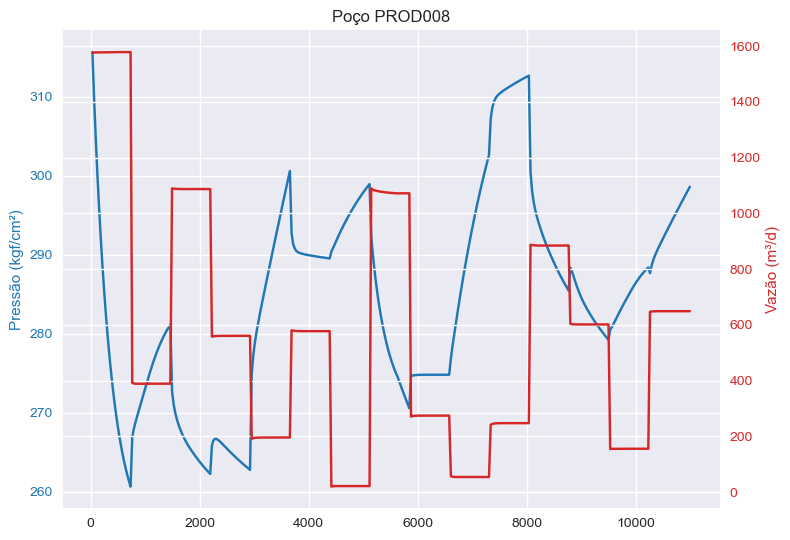

In [18]:
plt.style.use('seaborn-v0_8')

fig, ax1 = plt.subplots()

# Primeiro gráfico: Pressão
ax1.plot(tempo[1:], X[2530, :], color='tab:blue', label='Pressão')
ax1.set_ylabel("Pressão (kgf/cm²)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Poço PROD008")

# Segundo gráfico: Vazão (eixo y secundário)
ax2 = ax1.twinx()
ax2.plot(tempo[1:], U[41, :], color='tab:red', label='Vazão')
ax2.set_ylabel("Vazão (m³/d)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [19]:
kh=k-20 # int(k/2)  # usando metade do tempo total para histórico e o resto para previsã2

## 2.3 Redução de ordem

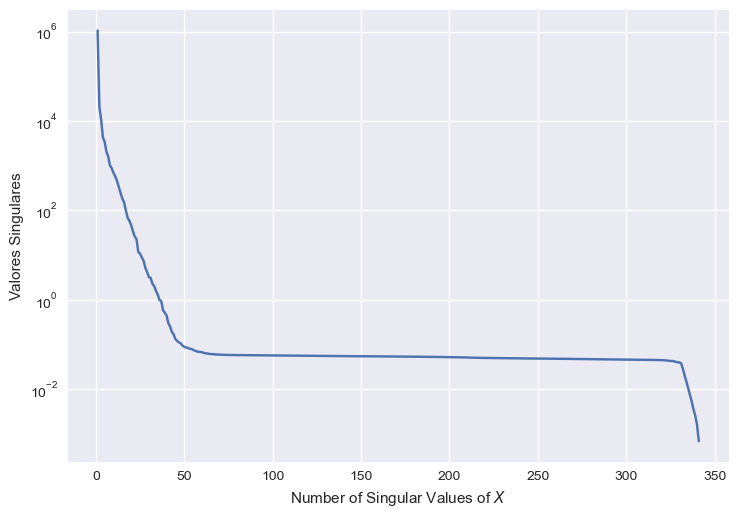

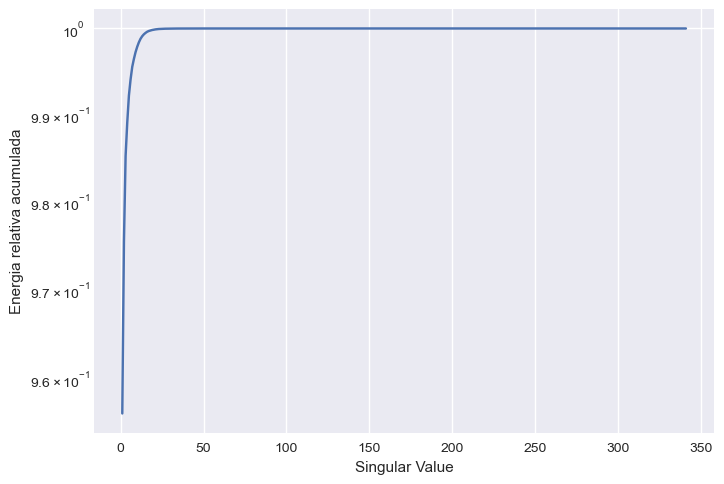

In [21]:
Phi,S,W = np.linalg.svd(X[:,:kh], full_matrices=False)

plt.style.use('seaborn-v0_8')

x = range(1, len(S)+1)
plt.plot(x,S)
fig = plt.gcf()
fig.set_size_inches(12.8/1.5, 8.8/1.5)
plt.yscale("log")
plt.xlabel("Number of Singular Values of $X$")
plt.ylabel("Valores Singulares")
# plt.grid()
plt.show()


plt.semilogy(x,np.cumsum(S) / np.sum(S))  #pode-se usar também o quadrado dos valores singulares
plt.xlabel("Singular Value")
plt.ylabel("Energia relativa acumulada")
# plt.grid()
plt.show()

In [22]:
#escolhendo r
r=15

Phir=Phi[:,:r].copy()

# projetando
Xr=Phir.T@X[:,:kh]
x0r=Phir.T@x0

#calculando a derivada. para problemas mais complexos, usar derivada ao menos de 4a ordem
Xrdot=np.zeros((r,kh))
Xrdot[:,0]=(Xr[:,0]-x0r)/dt[0]
Xrdot[:,1:]=(Xr[:,1:]-Xr[:,:-1])/dt[1:kh]

## 2.4 Inferindo as matrizes

In [24]:
# Inferindo as matrizes
Gamma=np.vstack((Xr,U[:,:kh]))
O=np.zeros((r,r+p))

O,*_=np.linalg.lstsq(Gamma.T,Xrdot.T,rcond=None)
O=O.T

Ar=O[:,0:r]
Br=O[:,r:r+p]

print(f"O valor da norma do resíduo final é {np.linalg.norm(Xrdot-O@Gamma):.2e}")
print(f"Número condicional da Matriz Ar é {np.linalg.cond(Ar):.2e}")

O valor da norma do resíduo final é 4.76e+00
Número condicional da Matriz Ar é 1.18e+06


## 2.5 Calculando novos estados

In [26]:
# calculando novas matrizes
Xrhat=np.zeros((r,k+1))
Xrhat[:,0]=x0r

for i in range(1,k+1):
    mat1=np.eye(r)-dt[i-1]*Ar
    mat2=Xrhat[:,i-1]+dt[i-1]*Br@U[:,i-1]
    Xrhat[:,i]=np.linalg.solve(mat1,mat2)
Xhat=Phir@Xrhat

In [27]:
# Teste simples de consistência dos resultados

if np.any(np.abs(Xorig-Xhat) > 2*np.max(np.abs(Xorig))):
    raise ValueError("Erro: Xhat não é estável.")
else:
    print("Xhat é estável.")

Xhat é estável.


## 2.5 Visualização dos Resultados

In [29]:

# Lista das células zero-based (número da célula - 1)
celulas = [2873,	2856,	3446,	2137,	11049,	2530,	31524,	3519,	1909,	1589,	3429,	34895,	7675,	25572]
celulas = [c - 1 for c in celulas]  # zero-based

# Rótulos dos poços
rotulos = {
     2872:	"NA1A",
     2855:	"NA2",
     3445:	"NA3D",
     2136:	"RJS19",
    11048:	"PROD005",
     2529:	"PROD008",
    31523:	"PROD009",
     3518:	"PROD010",
     1908:	"PROD012",
     1588:	"PROD014",
     3428:	"PROD021",
    34894:	"PROD023A",
     7674:	"PROD024A",
    25571:	"PROD025A"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(celulas):
    ax = axs[idx]
    ax.plot(tempo[:kh], Xorig[cid, :kh], 'ro', label="Hist")
    if (kh<k):
        ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(Xhat[cid, :]), np.max(Xhat[cid, :])], "--")
        ax.plot(tempo[kh:], Xorig[cid, kh:], 'r*', label="Prev")
    ax.plot(tempo, Xhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pressure - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgfm/cm2)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(celulas), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## 2.7 **Discussão sobre estabilidade**

A solução encontrada é instável, i.e., com o passar do tempo os valores estão indo para infinito, em módulo. Precisamos agora falar um pouco sobre estabilidade da solução.

A equação de espaço de estados é da forma:
$$\frac{d \mathbf{x}(t)}{dt}=\mathbf{A}_r\mathbf{x}(t)+\mathbf{B}_r\mathbf{u}(t)$$
Como sabermos previamente se sua solução é instável ou não? Vamos primeiro resolvê-la de forma analítica.


Aplicando a transformada de Laplace em ambos os lados da equação e lembrando que:

$$
\mathcal{L}\left\{ \frac{d\mathbf{x}(t)}{dt} \right\} = s\mathbf{X}(s) - \mathbf{x}(0)
\quad \text{e} \quad
\mathcal{L}\{\mathbf{A}_r\mathbf{x}(t)\} = \mathbf{A}_r\mathbf{X}(s), \quad \mathcal{L}\{\mathbf{B}_r\mathbf{u}(t)\} = \mathbf{B}_r\mathbf{U}(s),
$$

obtemos:

$$
s\mathbf{X}(s) - \mathbf{x}_0 = \mathbf{A}_r\mathbf{X}(s) + \mathbf{B}_r\mathbf{U}(s)
$$

Reagrupando os termos:

$$
(s\mathbf{I} - \mathbf{A}_r)\mathbf{X}(s) = \mathbf{x}_0 + \mathbf{B}_r\mathbf{U}(s)
$$

Multiplicando ambos os lados pela inversa de $(s\mathbf{I} - \mathbf{A}_r)$, temos:

$$
\mathbf{X}(s) = (s\mathbf{I} - \mathbf{A}_r)^{-1} \mathbf{x}_0 + (s\mathbf{I} - \mathbf{A}_r)^{-1} \mathbf{B}_r \mathbf{U}(s)
$$

Aplicando a transformada inversa de Laplace, usamos as seguintes identidades:

$$
\mathcal{L}^{-1}\left\{(s\mathbf{I} - \mathbf{A}_r)^{-1} \right\} = e^{\mathbf{A}_rt}
\quad \text{e} \quad
\mathcal{L}^{-1} \left\{ (s\mathbf{I} - \mathbf{A}_r)^{-1} \mathbf{B}_r \mathbf{U}(s) \right\} = \int_0^t e^{\mathbf{A}_r(t - \tau)} \mathbf{B}_r \mathbf{u}(\tau) \, d\tau
$$

Assim, a solução no domínio do tempo é dada por:

$$
\boxed{
\mathbf{x}(t) = e^{\mathbf{A}_rt} \mathbf{x}_0 + \int_0^t e^{\mathbf{A}_r(t - \tau)} \mathbf{B}_r \mathbf{u}(\tau) \, d\tau
}
$$

Esta é a forma geral da solução do sistema linear com entrada arbitrária $ \mathbf{u}(t) $.

Nesta solução:
- O termo $ e^{\mathbf{A}_r t} \mathbf{x}_0 $ é chamado de **resposta livre** (ou homogênea),
- O termo integral é chamado de **resposta forçada** (ou particular), que depende da entrada $\mathbf{u}(t)$.



A resposta livre pode ser escrita como:

$$
\mathbf{x}_h(t) = e^{\mathbf{A}_r t} \mathbf{x}_0
$$

Para entender seu comportamento ao longo do tempo, analisamos a matriz exponencial $ e^{\mathbf{A}_r t} $.



Sejam $\lambda_1, \lambda_2, \ldots, \lambda_n$ os autovalores de $\mathbf{A}_r$. Suponha que $\mathbf{A}_r$ seja diagonalizável, ou seja,

$$
\mathbf{A}_r = \mathbf{P} \mathbf{D} \mathbf{P}^{-1},
$$

onde

- $\mathbf{D} = \mathrm{diag}(\lambda_1, \lambda_2, \ldots, \lambda_n)$ contém os autovalores de $\mathbf{A}_r$,
- As colunas de $\mathbf{P}$ são os autovetores correspondentes.







A matriz exponencial é definida pela série de potências

$$
e^{\mathbf{A}_r t} = \sum_{k=0}^{\infty} \frac{(\mathbf{A}_r t)^k}{k!}.
$$

Substituindo $\mathbf{A}_r = \mathbf{P} \mathbf{D} \mathbf{P}^{-1}$:

$$
(\mathbf{A}_r)^k = (\mathbf{P} \mathbf{D} \mathbf{P}^{-1})^k.
$$


Note que

$$
(\mathbf{P} \mathbf{D} \mathbf{P}^{-1})^2 = \mathbf{P} \mathbf{D} \underbrace{\mathbf{P}^{-1} \mathbf{P}}_{I} \mathbf{D} \mathbf{P}^{-1} = \mathbf{P} \mathbf{D}^2 \mathbf{P}^{-1}.
$$

De forma análoga,

$$
(\mathbf{P} \mathbf{D} \mathbf{P}^{-1})^k = \mathbf{P} \mathbf{D}^k \mathbf{P}^{-1}.
$$


Assim, podemos reescrever a série da matriz exponencial como

$$
e^{\mathbf{A}_r t} = \sum_{k=0}^\infty \frac{(\mathbf{A}_r t)^k}{k!} = \sum_{k=0}^\infty \frac{\mathbf{P} \mathbf{D}^k \mathbf{P}^{-1} t^k}{k!} = \mathbf{P} \left(\sum_{k=0}^\infty \frac{\mathbf{D}^k t^k}{k!}\right) \mathbf{P}^{-1} = \mathbf{P} e^{\mathbf{D} t} \mathbf{P}^{-1}.
$$






Então,

$$
e^{\mathbf{A}_r t} = \mathbf{P} e^{\mathbf{D} t} \mathbf{P}^{-1} = \mathbf{P} \begin{bmatrix} e^{\lambda_1 t} & & \\ & \ddots & \\ & & e^{\lambda_n t} \end{bmatrix} \mathbf{P}^{-1}.
$$



O comportamento da solução depende da parte real dos autovalores $\lambda_i$:

- Se $\Re(\lambda_i) < 0$ para todo $i$, então $e^{\lambda_i t} \to 0$ conforme $t \to \infty$, e assim

$$
\mathbf{x}_h(t) \to \mathbf{0}.
$$

- Se existir algum autovalor com $\Re(\lambda_i) > 0$, então a resposta cresce exponencialmente e

$$
\|\mathbf{x}_h(t)\| \to \infty,
$$

indicando instabilidade.

- Se algum autovalor tem $\Re(\lambda_i) = 0$ (e multiplicidade maior que 1), pode haver crescimento polinomial, o que caracteriza instabilidade marginal.

A resposta forçada é

$$\mathbf{x}_p(t) = \int_0^t e^{\mathbf{A}_r (t-\tau)} \mathbf{B}_r \mathbf{u}(\tau) \, d\tau.
$$

Suponha que a entrada $\mathbf{u}(t)$ seja limitada, ou seja, existe $M > 0$ tal que

$$
\|\mathbf{u}(t)\| \leq M, \quad \forall t \geq 0.
$$

Se $\Re(\lambda_i) < 0$ para todo $i$, então $e^{\mathbf{A}_r t}$ é **exponencialmente decrescente**, e existem constantes $K > 0$ e $\alpha > 0$ tais que

$$
\|e^{\mathbf{A}_r t}\| \leq K e^{-\alpha t}, \quad t \geq 0.
$$

Assim,

$$
\|\mathbf{x}_p(t)\| \leq \int_0^t \|e^{\mathbf{A}_r (t-\tau)}\| \|\mathbf{B}_r\| \|\mathbf{u}(\tau)\| d\tau \leq K \|\mathbf{B}_r\| M \int_0^t e^{-\alpha (t-\tau)} d\tau.
$$

Calculando a integral,

$$
\int_0^t e^{-\alpha (t-\tau)} d\tau = \int_0^t e^{-\alpha s} ds = \frac{1 - e^{-\alpha t}}{\alpha} \leq \frac{1}{\alpha}.
$$

Portanto,

$$
\|\mathbf{x}_p(t)\| \leq \frac{K \|\mathbf{B}_r\| M}{\alpha}, \quad \forall t \geq 0,
$$

ou seja, **limitada para todo $t$**.

A solução completa

$$
\mathbf{x}(t) = \mathbf{x}_h(t) + \mathbf{x}_p(t)
$$

será **limitada para toda condição inicial limitada e toda entrada limitada** se, e somente se,

$$
\boxed{
\Re(\lambda_i) < 0, \quad \forall i = 1, \ldots, n.
}
$$


Vamos checar os autovalores de $\mathbf{A}_r$ no seguinte gráfico de Argand-Gauss

In [37]:
def verifica_estabilidade(Ar=Ar):
    # Calcula autovalores
    eigvals = np.linalg.eigvals(Ar)
    
    # Separa os autovalores por categoria
    pos_real = eigvals[np.real(eigvals) > 1e-12]
    neg_real = eigvals[np.real(eigvals) < -1e-12]
    neutral = eigvals[np.abs(np.real(eigvals)) <= 1e-12]
    
    # Plotagem
    plt.figure(figsize=(8, 6))
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    
    plt.scatter(np.real(pos_real), np.imag(pos_real), color='red', label='Parte real > 0')
    plt.scatter(np.real(neg_real), np.imag(neg_real), color='green', label='Parte real < 0')
    plt.scatter(np.real(neutral), np.imag(neutral), color='orange', label='Parte real ≈ 0')
    
    # for val in eigvals:
        # plt.text(np.real(val), np.imag(val), f'{val:.2f}', fontsize=9, ha='right', va='bottom')
    
    plt.title('Autovalores de $\\mathbf{A}_r$ no Plano Complexo')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.grid(True)
    plt.legend()
    plt.show()

    if len(pos_real)>0:
        print(f'A matriz Ar possui {len(pos_real)} de {len(pos_real)+len(neg_real)+len(neutral)} auto-valores com parte real positiva. Logo, Ar é Instável!')
    else:
        print(f'A matriz Ar possui todos os seus auto-valores com parte real não-positiva. Logo, Ar é Estável!')
    
verifica_estabilidade(Ar)    

A matriz Ar possui 4 de 15 auto-valores com parte real positiva. Logo, Ar é Instável!


Vamos implementar o método de reposição de polos


In [109]:
import numpy as np
import scipy.linalg as la


# Projeção espectral para garantir estabilidade
def estabilize_A(A, epsilon=10):
    autovalores_orig, autovetores = la.eig(A)
    minimo=np.min(np.real(autovalores_orig))*epsilon
    # Projeta os autovalores: se Re(λ) >= 0, substitui por epsilon (parte real negativa)
    autovalores_proj = []
    for val in autovalores_orig:
        if np.real(val) < 0:
            autovalores_proj.append(val)  # já é estável
        else:
            novo_val = minimo + 1j * np.imag(val)  # ajusta apenas a parte real
            autovalores_proj.append(novo_val)
    
    # Constrói matriz diagonal com autovalores projetados
    D_proj = np.diag(autovalores_proj)
    
    # Reconstrói A estável: A_estavel = V * D_proj * V^{-1}
    A_estavel = autovetores @ D_proj @ la.inv(autovetores)
    return A_estavel, autovalores_orig, np.array(autovalores_proj)



In [103]:
autovalores_orig, autovetores = la.eig(Ar)

In [107]:
np.min(np.real(autovalores_orig))

-3.462493253828768

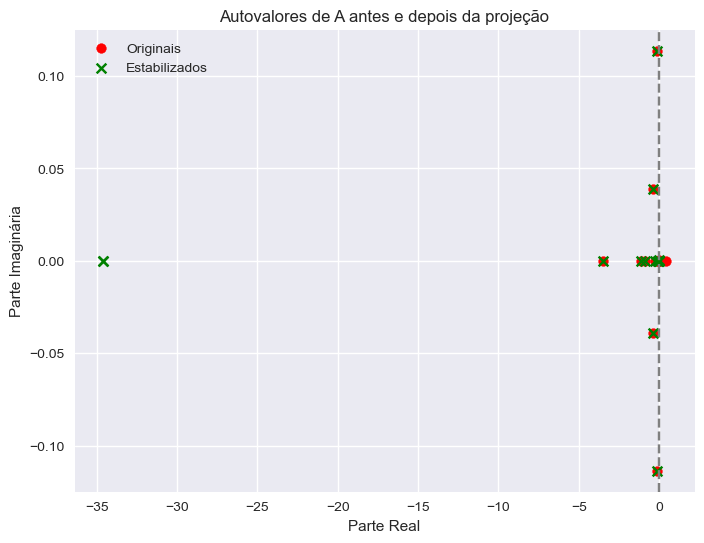

A matriz Ar possui todos os seus auto-valores com parte real não-positiva. Logo, Ar é Estável!


In [111]:
Ar_novo,eigvals_orig, eigvals_estab=estabilize_A(Ar)

# Visualização
plt.figure(figsize=(8, 6))
plt.axvline(0, color='gray', linestyle='--')
plt.scatter(eigvals_orig.real, eigvals_orig.imag, color='red', label='Originais')
plt.scatter(eigvals_estab.real, eigvals_estab.imag, color='green', marker='x', label='Estabilizados')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.title('Autovalores de A antes e depois da projeção')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.show()

# verifica_estabilidade(Ar)
verifica_estabilidade(Ar_novo)

In [113]:
O_novo=np.hstack((Ar_novo,Br))
print(f"Norma do resíduo com Ar instável: {np.linalg.norm(Xrdot-O@Gamma,'fro'):.2e}")
print(f"Norma do resíduo com Ar estável: {np.linalg.norm(Xrdot-O_novo@Gamma,'fro'):.2e}")

Norma do resíduo com Ar instável: 1.72e+01
Norma do resíduo com Ar instável: 3.25e+06


In [41]:
# calculando novas matrizes
Xrhat=np.zeros((r,k+1))
Xrhat[:,0]=x0r


for i in range(1,k+1):
    mat1=np.eye(r)-dt[i-1]*Ar_novo
    mat2=Xrhat[:,i-1]+dt[i-1]*Br@U[:,i-1]
    Xrhat[:,i]=np.linalg.solve(mat1,mat2)
Xhat=Phir@Xrhat

C:\Users\mateu\AppData\Local\Temp\ipykernel_16156\1201984431.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  Xrhat[:,i]=np.linalg.solve(mat1,mat2)


Apesar de uma solução $x(t)$ ser instável porque a matriz $A$ tem autovalores reais positivos, a depender da condição inicial $x0$ a resposta pode ainda sim ser estável. Basta a condição inicial ser ortogonal aos autovetores instaveis.

In [43]:
import numpy as np

def verifica_estabilidade_x0(A, x0, tol=1e-8):
    """
    Verifica se a condição inicial x0 tem componente instável para o sistema dx/dt = A x.

    Parâmetros:
    A (ndarray): Matriz de sistema (nxn).
    x0 (ndarray): Condição inicial (n,).
    tol (float): Tolerância para considerar uma projeção como zero.

    Retorna:
    instavel (bool): True se x0 tem componente instável, False caso contrário.
    detalhes (dict): Informações sobre autovalores instáveis e projeções.
    """

    eigvals, eigvecs = np.linalg.eig(A)

    # Autovalores com parte real positiva (instáveis)
    instaveis_idx = np.where(np.real(eigvals) > 0)[0]

    detalhes = {
        "autovalores_instaveis": eigvals[instaveis_idx],
        "projecoes": []
    }

    # Checar projeção de x0 nos autovetores instáveis
    for i in instaveis_idx:
        v = eigvecs[:, i]
        # Normalizar o autovetor para projeção consistente
        v = v / np.linalg.norm(v)
        proj = np.abs(np.dot(np.conj(v), x0))
        detalhes["projecoes"].append(proj)

    # Se qualquer projeção for maior que tolerância, x0 é instável
    instavel = any(proj > tol for proj in detalhes["projecoes"])

    return instavel, detalhes


In [44]:
instavel, info = verifica_estabilidade_x0(Ar, x0r)

if instavel:
    print("A condição inicial x0 tem componente instável!")
    print("Autovalores instáveis: \n",info["autovalores_instaveis"])
    print("Projeções: \n",info["projecoes"])
else:
    print("A condição inicial x0 é estável (não possui componente instável).")

A condição inicial x0 tem componente instável!
Autovalores instáveis: 
 [8.45919517+0.j         3.35373669+0.j         0.98324657+0.53877193j
 0.98324657-0.53877193j]
Projeções: 
 [1629.5274270300822, 5439.7253747484265, 742.5987095813161, 742.5987095813161]


## 2.8 Regularização

Por que regularização?

Inserindo uma regularização na função objetivo original acaba penalizand soluções com norma grande (que frequentemente são instáveis), também suaviza o ajuste aos dados (controla o overfitting), amortece direções mal condicionadas da matriz de dados e, como efeito colateral, puxa os autovalores da matriz A para regiões mais estáveis.

A regularização ajuda mas não necessariamente resolve o problema da instabilidade!

Nova funcão objetivo adiciona agora um regularizador para auxiliar na solução do sistema
$$FO(\mathbf{X})=\|\dot{\mathbf{X}}-\mathbf{O}\boldsymbol{\Gamma}\|^2_F+\|\lambda\mathbf{O}\|^2_F$$

Fazendo $\frac{\partial FO}{\partial O}=0$ obtemos (mostre!!!):
$$\mathbf{O}(\boldsymbol{\Gamma}\boldsymbol{\Gamma}^T+\lambda^2\mathbf{I})=\dot{\mathbf{X}}\boldsymbol{\Gamma}^T$$
ou
$$(\boldsymbol{\Gamma}\boldsymbol{\Gamma}^T+\lambda^2\mathbf{I})\mathbf{O}^T=\boldsymbol{\Gamma}\dot{\mathbf{X}}^T$$
Onde $\lambda$ é o mínimo escalar que faça com que o sistema seja estável. E como saber qual é esse valor?


**Curva L**


![Texto alternativo](L-curve.png)


In [50]:
import numpy as np
import plotly.graph_objects as go

valores_lamb = np.logspace(-4, 6, num=20)

norma_residuo=[]
norma_sol=[]
for i in range(len(valores_lamb)):
    lamb = valores_lamb[i]

    O,*_=np.linalg.lstsq(Gamma@Gamma.T+lamb**2*np.eye(r+p),Gamma@Xrdot.T,rcond=None)
    O = O.T
    residuo = Xrdot - O @ Gamma
    norma_residuo.append(np.linalg.norm(residuo, 'fro'))
    norma_sol.append(np.linalg.norm(O,'fro'))

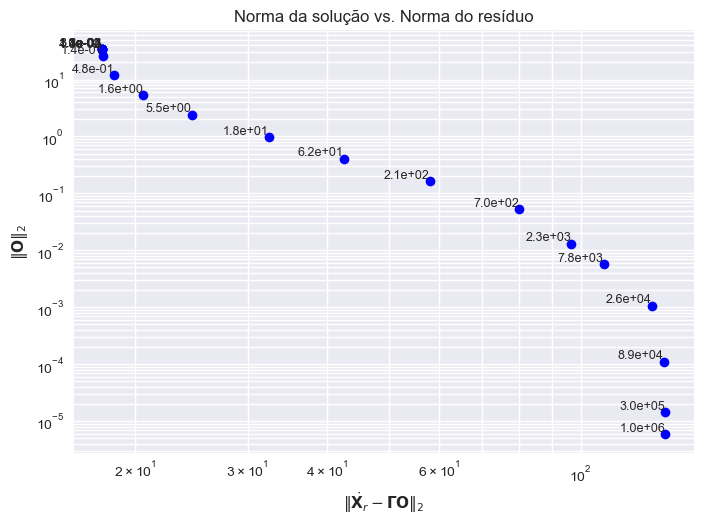

In [51]:
# Gráfico log-log da norma do resíduo vs norma da solução
plt.loglog(norma_residuo, norma_sol, 'bo')
plt.xlabel(r'$\|\dot{\mathbf{X}}_r - \boldsymbol{\Gamma} \mathbf{O}\|_2$')
plt.ylabel(r'$\|\mathbf{O}\|_2$')
plt.title('Norma da solução vs. Norma do resíduo')
plt.grid(True, which="both")#, ls="--")

# Anotar os pontos com os valores de lambda correspondentes
for i, val in enumerate(valores_lamb):
    plt.text(norma_residuo[i], norma_sol[i], f'{val:.1e}', fontsize=9, ha='right', va='bottom')

plt.show()


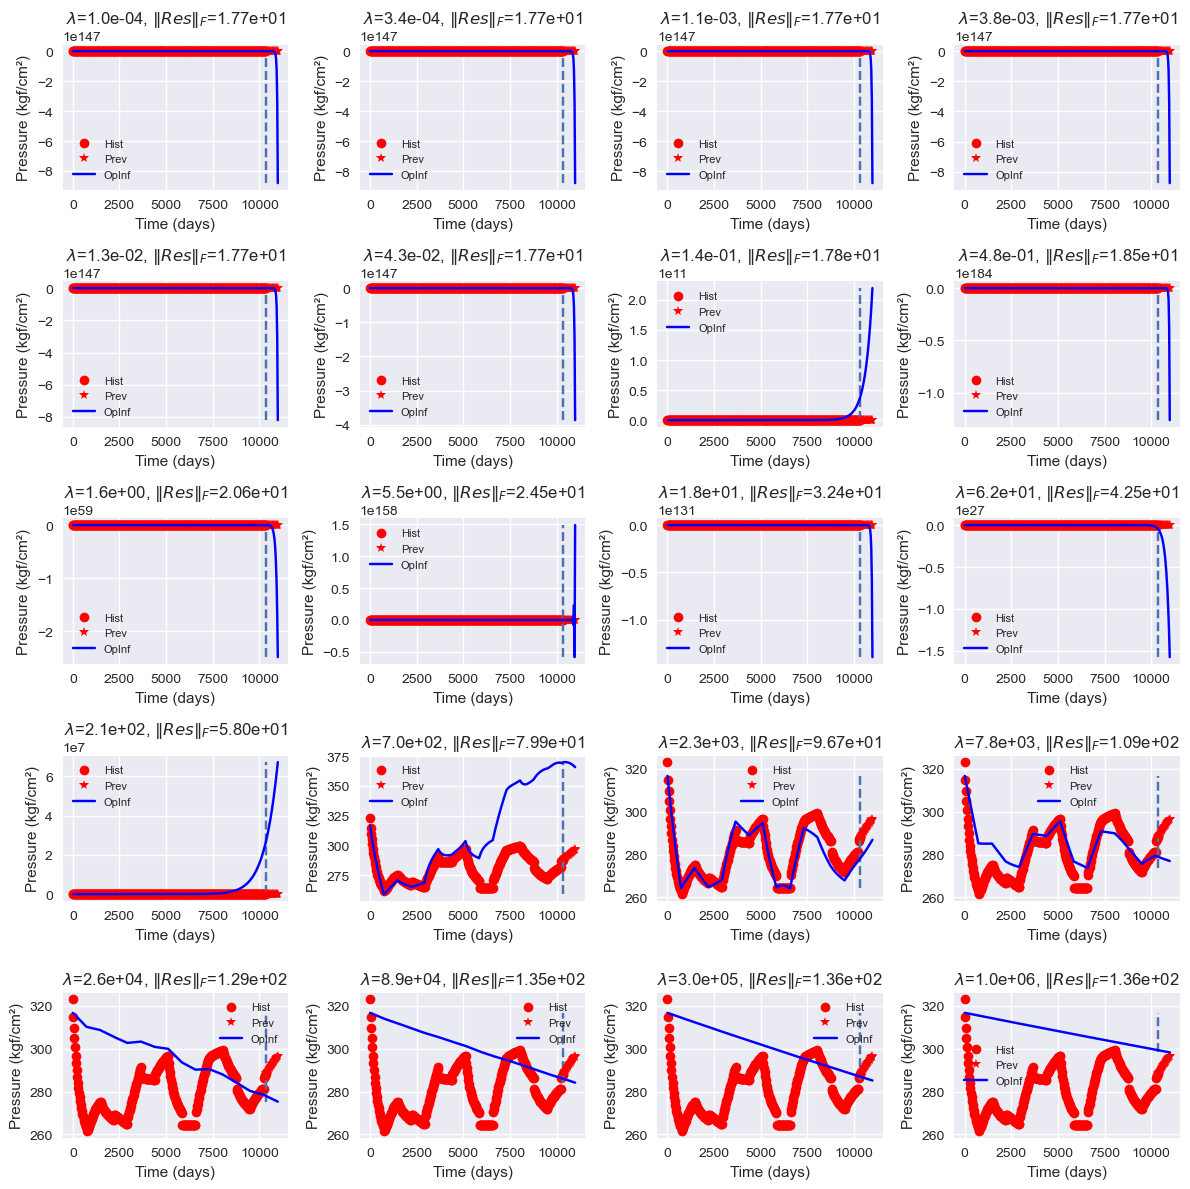

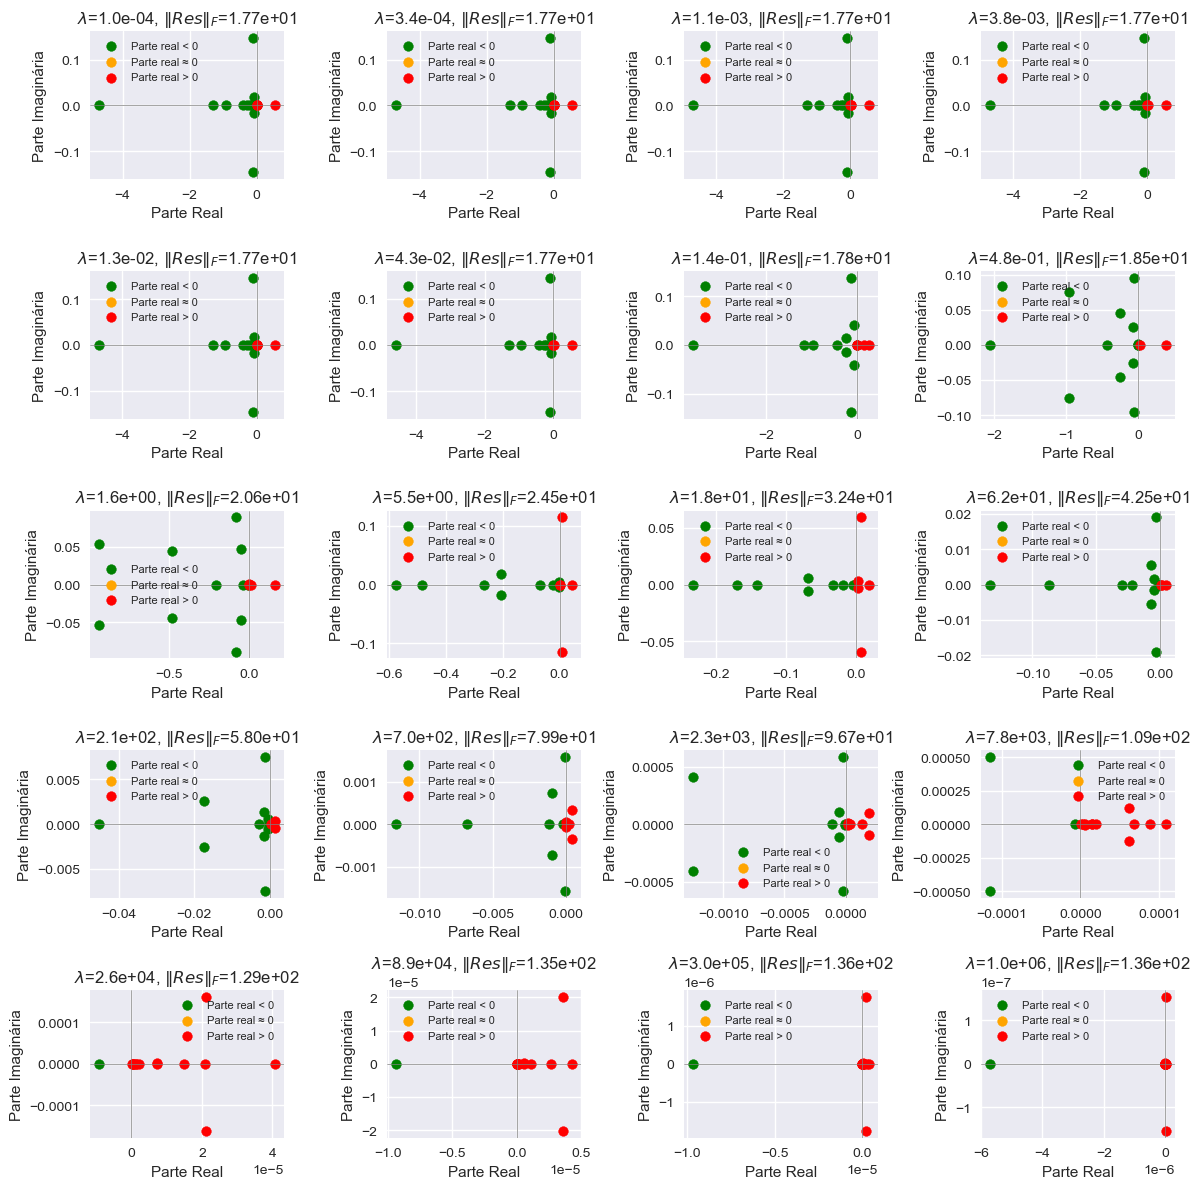

Lambda ótimo: 1.13e-03
Norma do resíduo mínima: 1.77e+01


In [52]:
# Criar figuras com subplots: 5 linhas, 4 colunas
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.flatten()

fig2, axs2 = plt.subplots(5, 4, figsize=(12, 12))
axs2 = axs2.flatten()

valores_lamb = np.logspace(-4, 6, num=20)
norma_residuo = []

for i, lamb in enumerate(valores_lamb):
    # Resolução do sistema regularizado
    O, *_ = np.linalg.lstsq(Gamma @ Gamma.T + lamb**2 * np.eye(r + p), Gamma @ Xrdot.T, rcond=None)
    O = O.T
    
    # Cálculo do resíduo e norma Frobenius
    residuo = Xrdot - O @ Gamma
    norma = np.linalg.norm(residuo, 'fro')
    norma_residuo.append(norma)

    Ar = O[:, :r]
    Br = O[:, r:r + p]

    # Análise de estabilidade: autovalores de Ar
    eigvals = np.linalg.eigvals(Ar)
    pos_real = eigvals[np.real(eigvals) > 1e-12]
    neg_real = eigvals[np.real(eigvals) < -1e-12]
    neutral = eigvals[np.abs(np.real(eigvals)) <= 1e-12]

    # Plot dos autovalores
    ax2 = axs2[i]
    ax2.axhline(0, color='gray', lw=0.5)
    ax2.axvline(0, color='gray', lw=0.5)
    ax2.scatter(np.real(neg_real), np.imag(neg_real), color='green', label='Parte real < 0')
    ax2.scatter(np.real(neutral), np.imag(neutral), color='orange', label='Parte real ≈ 0')
    ax2.scatter(np.real(pos_real), np.imag(pos_real), color='red', label='Parte real > 0')
    ax2.set_title(rf"$\lambda$={lamb:.1e}, $\|Res\|_F$={norma:.2e}")
    ax2.set_xlabel('Parte Real')
    ax2.set_ylabel('Parte Imaginária')
    ax2.grid(True)
    ax2.legend(fontsize=8)

    # Simulação com o modelo inferido
    Xrhat = np.zeros((r, k + 1))
    Xrhat[:, 0] = x0r

    for j in range(1, k + 1):
        mat1 = np.eye(r) - dt[j - 1] * Ar
        mat2 = Xrhat[:, j - 1] + dt[j - 1] * Br @ U[:, j - 1]
        Xrhat[:, j] = np.linalg.solve(mat1, mat2)

    Xhat = Phir @ Xrhat

    # Plot da pressão
    ax = axs[i]
    ax.plot(tempo[:kh], Xorig[2872, :kh], 'ro', label="Hist")
    if kh < k:
        ax.plot([tempo[kh - 1], tempo[kh - 1]], [np.min(Xhat[2872, :]), np.max(Xhat[2872, :])], "--")
        ax.plot(tempo[kh:], Xorig[2872, kh:], 'r*', label="Prev")
    ax.plot(tempo, Xhat[2872, :], 'b', label="OpInf")
    ax.set_title(rf"$\lambda$={lamb:.1e}, $\|Res\|_F$={norma:.2e}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgf/cm²)")
    ax.legend(fontsize=8)

# Ajustes finais e exibição
fig.tight_layout()
fig2.tight_layout()
plt.show()

# ▶ Encontrar o índice do menor resíduo
idx_min = np.argmin(norma_residuo)
lambda_otimo = valores_lamb[idx_min]

print(f"Lambda ótimo: {lambda_otimo:.2e}")
print(f"Norma do resíduo mínima: {norma_residuo[idx_min]:.2e}")

In [53]:
lamb=2.3e3 #lambda_otimo #4.8e-1
O,*_=np.linalg.lstsq(Gamma@Gamma.T+lamb**2*np.eye(r+p),Gamma@Xrdot.T,rcond=None)
O=O.T

norma = np.linalg.norm(Xrdot - O @ Gamma, 'fro')
print(f"Norma do resíduo mínima: {norma:.2e}")

Ar=O[:,0:r]
Br=O[:,r:r+p]
print(f"Número condicional da Matriz Ar é {np.linalg.cond(Ar):.2e}")

Norma do resíduo mínima: 9.66e+01
Número condicional da Matriz Ar é 8.88e+03


In [54]:
# calculando novas matrizes
Xrhat=np.zeros((r,k+1))
Xrhat[:,0]=x0r


for i in range(1,k+1):
    mat1=np.eye(r)-dt[i-1]*Ar
    mat2=Xrhat[:,i-1]+dt[i-1]*Br@U[:,i-1]
    Xrhat[:,i]=np.linalg.solve(mat1,mat2)
Xhat=Phir@Xrhat

## 2.9 Visualização dos Resultados

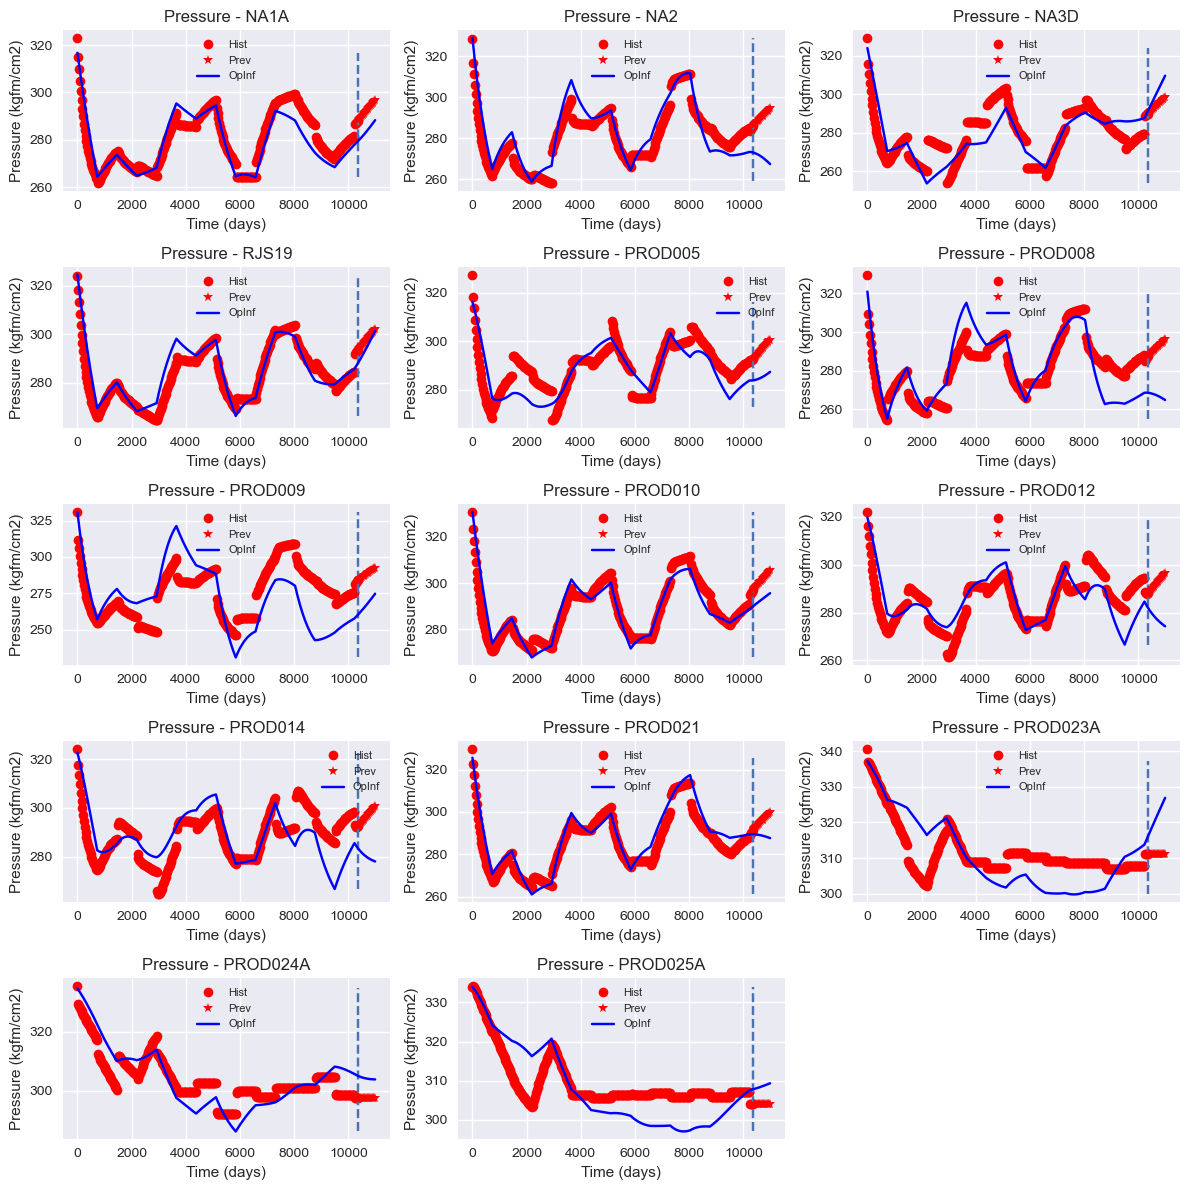

In [56]:

# Lista das células zero-based (número da célula - 1)
celulas = [2873,	2856,	3446,	2137,	11049,	2530,	31524,	3519,	1909,	1589,	3429,	34895,	7675,	25572]
celulas = [c - 1 for c in celulas]  # zero-based

# Rótulos dos poços
rotulos = {
     2872:	"NA1A",
     2855:	"NA2",
     3445:	"NA3D",
     2136:	"RJS19",
    11048:	"PROD005",
     2529:	"PROD008",
    31523:	"PROD009",
     3518:	"PROD010",
     1908:	"PROD012",
     1588:	"PROD014",
     3428:	"PROD021",
    34894:	"PROD023A",
     7674:	"PROD024A",
    25571:	"PROD025A"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(celulas):
    ax = axs[idx]
    ax.plot(tempo[:kh], Xorig[cid, :kh], 'ro', label="Hist")
    if (kh<k):
        ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(Xhat[cid, :]), np.max(Xhat[cid, :])], "--")
        ax.plot(tempo[kh:], Xorig[cid, kh:], 'r*', label="Prev")
    ax.plot(tempo, Xhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pressure - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgfm/cm2)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(celulas), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## 2.10 Regularização por Matriz

Em alguns casos mais complexos, principalmente quando se faz necessário a componente quadrática ou de maior ordem, é preciso separar os regularizadores por matriz a ser inferida. Com isso, a resposta tende a ficar melhor.

Nova funcão objetivo:
$$FO(\mathbf{X})=\|\dot{\mathbf{X}}-\mathbf{O}\boldsymbol{\Gamma}\|^2_F+\|\boldsymbol{\Lambda}\mathbf{O}\|^2_F$$

Fazendo $\frac{\partial FO}{\partial O}=0$ obtemos (mostre!!!):
$$\mathbf{O}(\boldsymbol{\Gamma}\boldsymbol{\Gamma}^T+\boldsymbol{\Lambda}^T\boldsymbol{\Lambda})=\dot{\mathbf{X}}\boldsymbol{\Gamma}^T$$
ou
$$(\boldsymbol{\Gamma}\boldsymbol{\Gamma}^T+\boldsymbol{\Lambda}^T\boldsymbol{\Lambda})\mathbf{O}^T=\boldsymbol{\Gamma}\dot{\mathbf{X}}^T$$
A nova matriz $\boldsymbol{\Lambda}$ adicionada é uma matriz diagonal com os pesos que devem ser aplicados à matriz $\mathbf{O}$ e tem a seguinte estrutura:
$$\boldsymbol{\Lambda}=\begin{bmatrix}
\lambda_A&\cdots&0&0&\cdots&0\\
\vdots&\ddots&\vdots&\vdots&\ddots&\vdots\\
0&\cdots&\lambda_A&0&\cdots&0\\
0&\cdots&0&\lambda_B&\cdots&0\\
\vdots&\ddots&\vdots&\vdots&\ddots&\vdots\\
0&\cdots&0&0&\cdots&\lambda_B\\
\end{bmatrix}=\begin{bmatrix}\lambda_A\mathbf{I}&\mathbf{0}\\\mathbf{0}&\lambda_B\mathbf{I}\end{bmatrix}$$
Onde $\lambda$ é o mínimo escalar que faça com que o sistema seja estável.

In [59]:
import plotly.graph_objects as go

valores_lamb = np.logspace(-8, 6, num=20)
LambA_grid, LambB_grid = np.meshgrid(valores_lamb, valores_lamb)
Z_norma_residuo = np.zeros_like(LambA_grid)


for i in range(len(valores_lamb)):
    for j in range(len(valores_lamb)):
        lambA = valores_lamb[i]
        lambB = valores_lamb[j]

        Lamb = np.diag([lambA] * r + [lambB] * p)

        O, *_ = np.linalg.lstsq(Gamma @ Gamma.T + Lamb.T @ Lamb,
                                Gamma @ Xrdot.T, rcond=None)
        O = O.T
        residuo = Xrdot - O @ Gamma
        norma_residuo = np.linalg.norm(residuo, 'fro')
        Z_norma_residuo[i, j] = norma_residuo


# Convertendo para log10 para eixos
log_lambA = np.log10(LambA_grid)
log_lambB = np.log10(LambB_grid)
log_Z=np.log10(Z_norma_residuo)

fig = go.Figure(data=[go.Surface(
    z=log_Z, x=log_lambA, y=log_lambB,
    colorscale='Viridis',
    contours={"z": {"show": True, "usecolormap": True,
                    "highlightcolor":"limegreen", "project_z": True}},
)])

fig.update_layout(
    title='Norma do Resíduo vs λA e λB',
    scene=dict(
        xaxis_title='log10(λA)',
        yaxis_title='log10(λB)',
        zaxis_title='log10(norm residuo)'
    ),
    width=1000,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()


# ▶ Encontrar os índices do menor valor do resíduo
min_idx = np.unravel_index(np.argmin(Z_norma_residuo), Z_norma_residuo.shape)

# ▶ Obter os lambdas ótimos
lambdaA_otimo = valores_lamb[min_idx[0]]
lambdaB_otimo = valores_lamb[min_idx[1]]

print(f"Lambda A ótimo: {lambdaA_otimo:.2e}")
print(f"Lambda B ótimo: {lambdaB_otimo:.2e}")
print(f"Norma do resíduo mínima: {Z_norma_residuo[min_idx]:.2e}")

Lambda A ótimo: 8.86e-06
Lambda B ótimo: 2.34e-01
Norma do resíduo mínima: 1.72e+01


In [60]:
lambA = lambdaA_otimo #10**4
lambB = lambdaB_otimo #10**4

Lamb = np.diag([lambA] * r + [lambB] * p)

O, *_ = np.linalg.lstsq(Gamma @ Gamma.T + Lamb.T @ Lamb,
                        Gamma @ Xrdot.T, rcond=None)
O = O.T

norma_residuo = np.linalg.norm(Xrdot - O @ Gamma, 'fro')
print(f"A norma do resíduo = {norma_residuo:.2e}")
Ar = O[:, :r]
Br = O[:, r:r + p]


print(f"cond(Ar) = {np.linalg.cond(Ar):.2e}")

# calculando novas matrizes
Xrhat=np.zeros((r,k+1))
Xrhat[:,0]=x0r


for i in range(1,k+1):
    mat1=np.eye(r)-dt[i-1]*Ar
    mat2=Xrhat[:,i-1]+dt[i-1]*Br@U[:,i-1]
    Xrhat[:,i]=np.linalg.solve(mat1,mat2)
Xhat=Phir@Xrhat

A norma do resíduo = 1.72e+01
cond(Ar) = 8.21e+04


## 2.11 Visualização dos Resultados

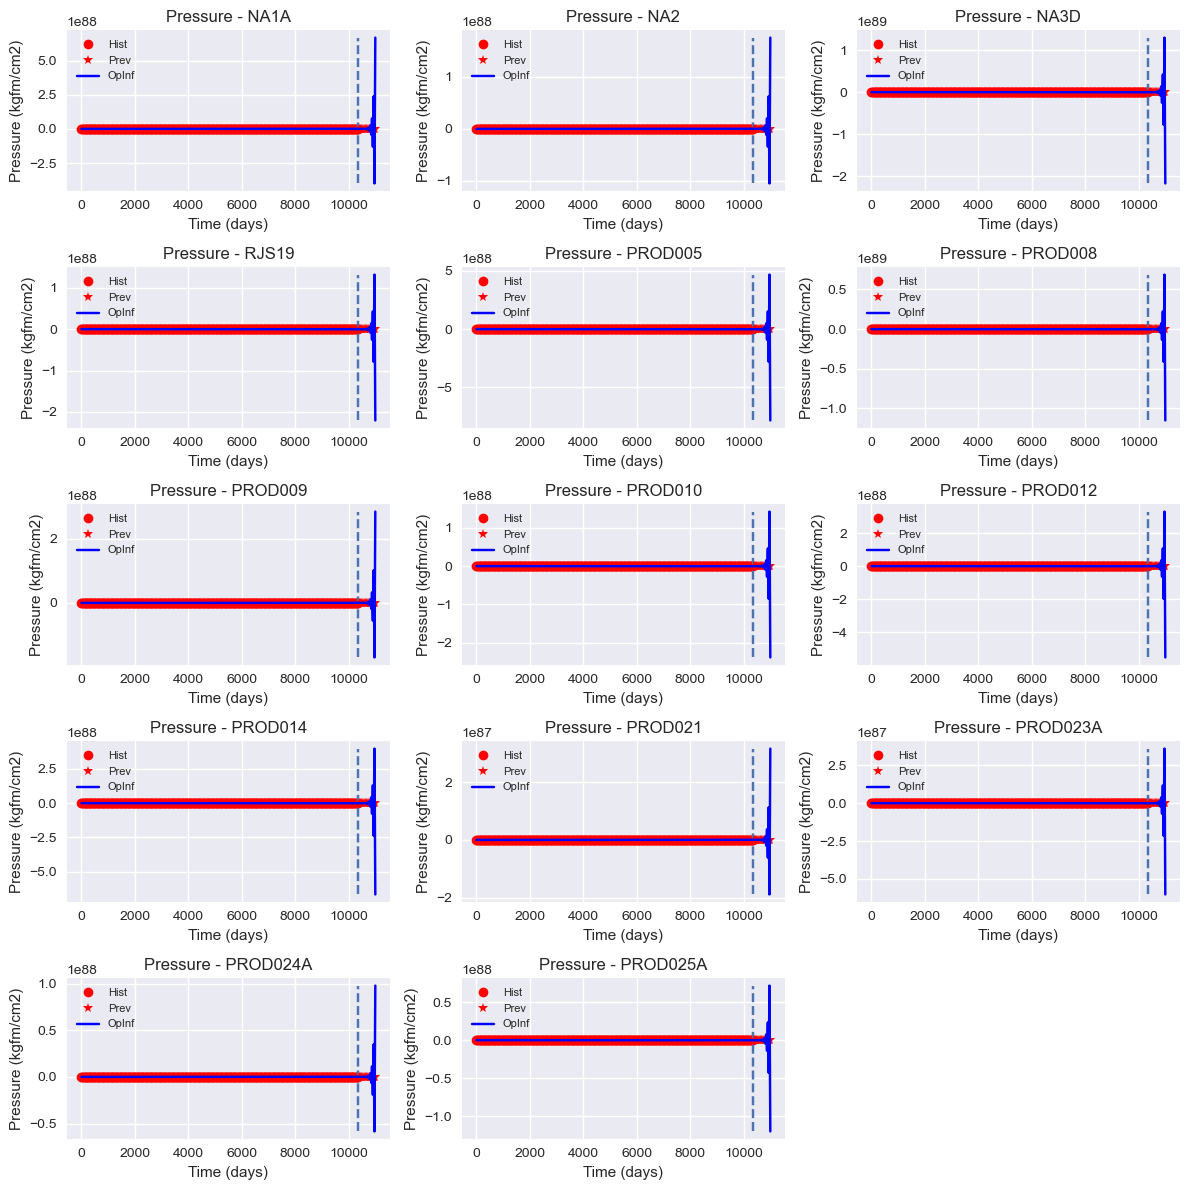

In [62]:

# Lista das células zero-based (número da célula - 1)
celulas = [2873,	2856,	3446,	2137,	11049,	2530,	31524,	3519,	1909,	1589,	3429,	34895,	7675,	25572]
celulas = [c - 1 for c in celulas]  # zero-based

# Rótulos dos poços
rotulos = {
     2872:	"NA1A",
     2855:	"NA2",
     3445:	"NA3D",
     2136:	"RJS19",
    11048:	"PROD005",
     2529:	"PROD008",
    31523:	"PROD009",
     3518:	"PROD010",
     1908:	"PROD012",
     1588:	"PROD014",
     3428:	"PROD021",
    34894:	"PROD023A",
     7674:	"PROD024A",
    25571:	"PROD025A"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(celulas):
    ax = axs[idx]
    ax.plot(tempo[:kh], Xorig[cid, :kh], 'ro', label="Hist")
    if (kh<k):
        ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(Xhat[cid, :]), np.max(Xhat[cid, :])], "--")
        ax.plot(tempo[kh:], Xorig[cid, kh:], 'r*', label="Prev")
    ax.plot(tempo, Xhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pressure - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgfm/cm2)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(celulas), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# 3 OpInf nos dados de poço

Como estamos mais interessados em observar os dados de pressão de fundo do poço, vamos aplicar o OpInf mais uma vez para resolver a seguinte equação de espaço de estados:
$$\mathbf{y}(t)=\mathbf{Cx}(t)+\mathbf{Du}(t)$$

Onde $\mathbf{y}(t)$ nesse caso representa as pressões de fundo (pwf). O vetor de estados $\mathbf{x}(t)$ a ser usado nesse caso é o mesmo calculado no passo passado. Para evitar mais etapas vamos usar já o vetor de estados na forma reduzida.

## 3.1 Inferindo as matrizes

In [66]:
GammaY=np.vstack((Xrhat[:,1:kh+1],U[:,:kh]))

OY=np.zeros((q,r+p))

OY,*_=np.linalg.lstsq(GammaY.T,PWF[:,:kh].T,rcond=None)
OY=OY.T

Chat=OY[:,0:r]
Dhat=OY[:,r:r+p]

## 3.2 Calculando as novas saídas

In [68]:
PWFhat=Chat@Xrhat[:,1:]+Dhat@U


norma_residuo = np.linalg.norm(PWF[:,:kh]-OY@GammaY,'fro')
print(f"A norma do resíduo = {norma_residuo:.2e}")

A norma do resíduo = 1.73e+04


## 3.3 Visualização dos resultados

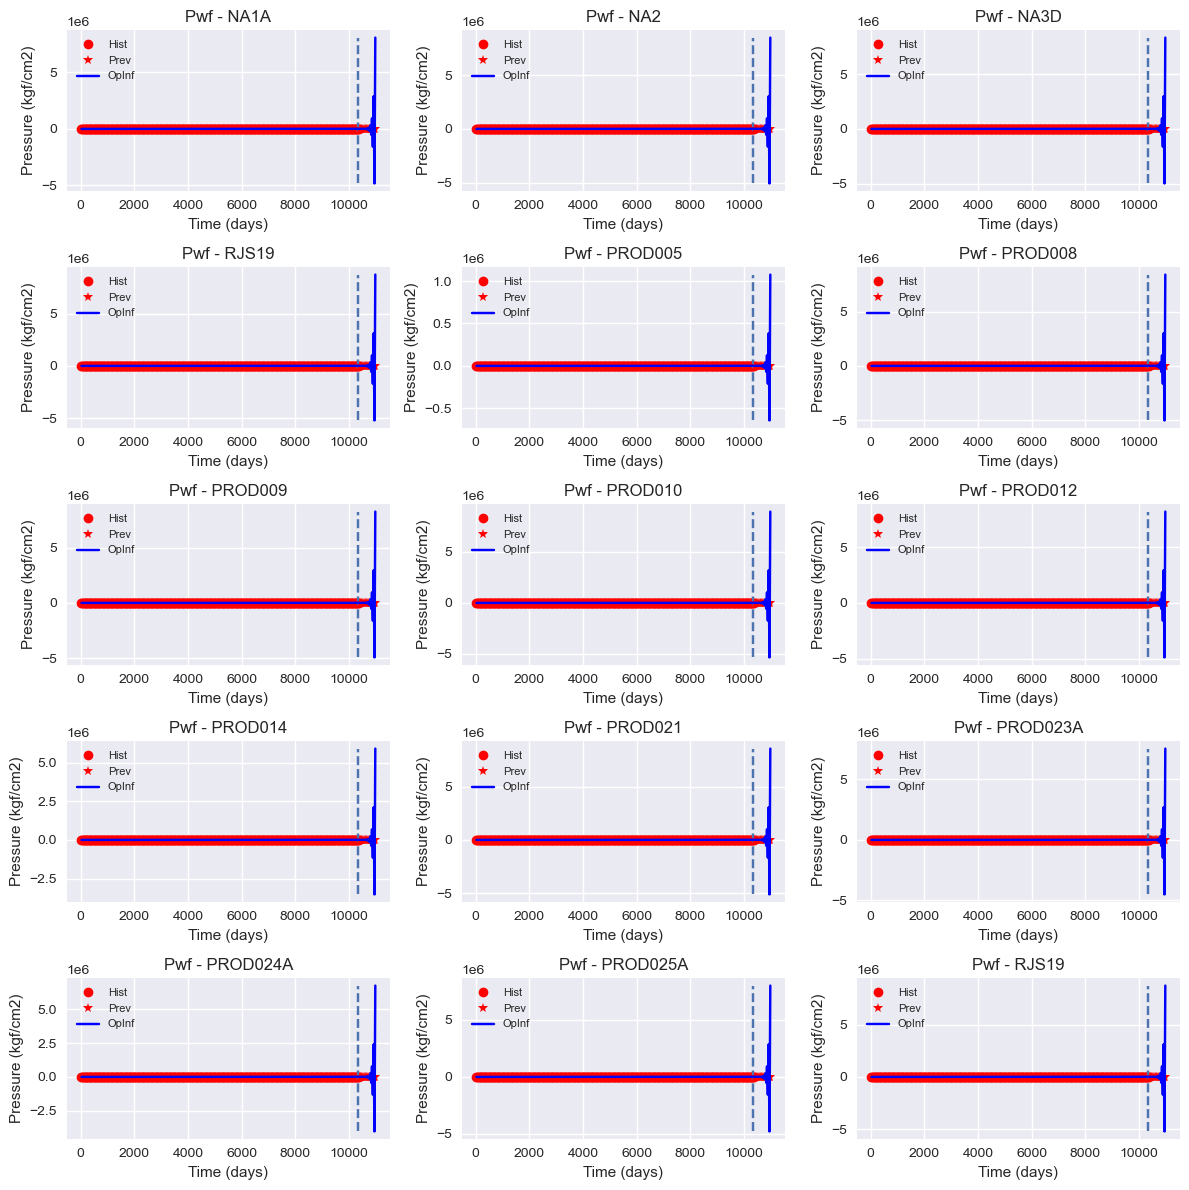

In [70]:

# Lista dos poços
posicao = [1, 2, 3, 14, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
posicao = [c - 1 for c in posicao]  # zero-based

# Rótulos dos poços
rotulos = {
     0:	"NA1A",
     1:	"NA2",
     2:	"NA3D",
    13:	"RJS19",
     3:	"PROD005",
     4:	"PROD008",
     5:	"PROD009",
     6:	"PROD010",
     7:	"PROD012",
     8:	"PROD014",
     9:	"PROD021",
    10:	"PROD023A",
    11:	"PROD024A",
    12:	"PROD025A"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(posicao):
    ax = axs[idx]
    ax.plot(tempo[1:kh+1], PWF[cid, :kh], 'ro', label="Hist")
    if (kh<k):
        ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(PWFhat[cid, :]), np.max(PWFhat[cid, :])], "--")
        ax.plot(tempo[kh+1:], PWF[cid, kh:], 'r*', label="Prev")  
    ax.plot(tempo[1:], PWFhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pwf - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgf/cm2)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(posicao), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()